# Normalization of edge features for intergraph comparation of the effect of edge relaxation
When considering edge features in a graph such as $\Delta ec = ec_{old} - ec_{new}$, one should be careful when using this parameter to compare different graphs, as for this particular example, if one graph has 1000 edge crossings and relaxing a certain edge removes one of them, we can consider it played little to no effect, however if another graph has 10 crossings and we remove one, that is a bettering of 10% compared ti the 0.1% seen before. And the fact is that the parameter $\Delta e_c$ conveys the same information in both cases.
We will therefore see a number of possible normalization processes for some of the edge attributes that we are dealing with.

## Edge crossings
Edge crossings are an inherent characteristic to a graph's drawing. They range from 0 to $\frac{(|E|-1)\cdot|E|}{2}$, and therefore the different in edge crossings ranges from - $\frac{(|E|-1)\cdot|E|}{2}$ to $\frac{(|E|-1)\cdot|E|}{2}$. It follows that a possible normalization procedure would be to divide $\delta e_c$ by $\frac{(|E|-1)\cdot|E|}{2}$, so as to get a value between -1 and 1.
Another possibility we can look at, which takes into account the graph's complexity is the reduction percentage, that we can define as $\frac{(ec_{old}-ec_{new})}{ec_{old}}$ which is close to 1 when we reduce the number of crossings significantly, 0 when we don't change it and negative when we worsen it. It's interesting to consider this variant as it allows for a qualitative improvement on the graph, not only numerical: we take into account how much has the graph gotten better, not only by how much it has changed.

## Expansion factor
This is a measure of disturbance of the drawing caused by he relaxation of an edge. It measures the distance between nodes before relaxing and nodes after relaxing and executing a couple more iterations of your favorite graph drawing algorithm (we will use Kamada Kawai). However, setting it to $\sum_{i=0}^{|V|}||x^{i}-f(x^{i})||$ allows bigger graphs with more nodes to have this parameter unusually high.
Therefore, we can consider normalizing in terms of the number of nodes: $\sum_{i=0}^{|V|}\frac{||x^{i}-f(x^{i})||}{|V|}$.
This way we have the disturbance per node and we don't discriminate in terms of the number of nodes of a graph.

## Gradient difference
We also measure the difference between the gradients of the Kamada Kawai before relaxing the edge and after. Note that because the non linear optimization looks for local optima, the gradient of the KK will possibly be zero after the execution and we measure the norm of the gradient after relaxing an edge. (Recomputing d(i,j)).
Therefore, our parameter could be $||\nabla(KK_{after}) - \nabla(KK_{before})||$. 

## Max degree of connecting nodes
This feature obviously increases as the size of our graph increases, and therefore it is a good idea to normalize it by dividing it by the total amount of nodes: $max_{v_i \in N_u}\frac{(deg(v_i)}{|V|}$

## Sum of degrees of connecting nodes
Similarly as for the max degree of connecting nodes, this feature increases with the size of our graph, and we therefore normalize it by dividing by the total amount of nodes: $\sum_{v_i \in N_u}\frac{deg(v_i)}{|V|}$

In [20]:
import numpy as np

def expansion_factor_norm(layout1: np.array, layout2: np.array) -> float:
    """
    Computes the normalized expansion factor.

    Args: 
    - layout1 (np.array) : layout of graph before relaxing the edge, nnodes*k array where k is the dimensionality of the drawing
    - layout2 (np.array) : layout of graph after relaxation of the edge and iterations of Kamada Kawai, nnodes*k array
    - nnodes (int) : Number of node of the graph

    Returns:
    - expansion factor normalized by nnodes (float)
    """
    nnodes = len(layout1)
    return np.sum([np.linalg.norm(layout1[i]-layout2[i]) for i in range(nnodes)])/nnodes

l1 = np.array([[3.12,7.23],[1.1,8.33],[3.43,4.3]])
l2 = np.array([[1,0],[1,2],[7,3]])
print(expansion_factor_norm(l1,l2,3))

# IMPORTANT: en graph train, estem per la diferència de estrés i la reducció del nombre de crossings fent un dibuix totalment nou.
# Per lògica i utilitat hauríem de partir del dibuix que ja tenim per calcular entre altres coses la diferència de gradient i el factor d'expansió
# Que tenen a veure en l'evolució dinàmica del dibuix, i per tant s'hauria de iterar sobre el mateix.

5.888175489579267


In [24]:
import networkx as nx

def sum_neighbour_degrees_norm(G: nx.Graph, e) -> float:
    """
    Computes the sum of degrees of edges connecting the edge normalized by the graph size (nnodes).

    Args:
    - G (nx.graph) : graph
    - e (edge) : edge 

    Returns:
    - sum of neighbour nodes normalized (float)
    """
    u,v = e
    return (G.degree[u]+G.degree[v])/len(G.nodes)

def max_neighbour_degrees_norm(G: nx.Graph, e) -> float:
    """
    Computes the max of degrees of edges connecting the edge normalized by the graph size (nnodes).

    Args:
    - G (nx.graph) : graph
    - e (edge) : edge 

    Returns:
    - max of neighbour nodes normalized (float)
    """
    u,v = e
    return max(G.degree[u],G.degree[v])/len(G.nodes)

G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(3,4),(7,3),(9,0)])
sum_neighbour_degrees_norm(G,(1,2))
max_neighbour_degrees_norm(G,(1,2))

0.2857142857142857

In [44]:
def gradient_kamada_kawai(layout:np.array, d: np.array) -> np.array:
    """
    Computes the gradient of the Kamada Kawai function and evaluates it at the given 2D layout.

    Args:
    - layout (np.array) : layout to evaluate gradient at
    - d (np.array) : symmetric matrix of size nnodes*nnodes with d_ij = d(i,j) ideal distance from i to j

    Returns:
    - gradient of the kamada kawai evaluated at the layout as a numpy array of the form [dx_11, dx_12, dx_21, dx_22, ...]
    """

    grad = np.array([0 for i in range(2*len(layout))], dtype=np.float64)
    for i in range(len(layout)):
        dx = np.sum([2*(layout[i][0]-layout[j][0])/d[i][j]*(1/d[i][j]-1/np.linalg.norm(layout[i,:]-layout[j,:])) if j!=i else 0. for j in range(len(layout))])
        dy = np.sum([2*(layout[i][1]-layout[j][1])/d[i][j]*(1/d[i][j]-1/np.linalg.norm(layout[i,:]-layout[j,:])) if j!=i else 0. for j in range(len(layout))])
        grad[2*i] = dx
        grad[2*i+1] = dy
    return grad

d = distance_matrix(G)

g = gradient_kamada_kawai(l1,d)
print(g)

[ 1.87397426  2.62758654 -2.94801656  2.39279414  1.0740423  -5.02038067]


In [45]:
def distance_matrix(G: nx.Graph) -> np.array:
    """
    Returns the distance matrix of the graph, defined by d[i][j] = shortest path length between node i and j.

    Args:
    - G (nx.graph): graph

    Returns:
    - distance matrix as a numpy array

    Note: Heavily inspired by nx source code.
    """
    nNodes = len(G)
    dist = dict(nx.shortest_path_length(G, weight=None))
    dist_mtx = 1e6 * np.ones((nNodes, nNodes))
    for row, nr in enumerate(G):
        if nr not in dist:
            continue
        rdist = dist[nr]
        for col, nc in enumerate(G):
            if nc not in rdist:
                continue
            dist_mtx[row][col] = rdist[nc]
    return dist_mtx

d = distance_matrix(G)
dict_layout = nx.kamada_kawai_layout(G)
arr_layout = []
for node in dict_layout.keys():
    arr_layout.append(dict_layout[node])
arr_layout = np.array(arr_layout)
print(np.linalg.norm(g))
g = gradient_kamada_kawai(arr_layout,distance_matrix(G))
print(np.linalg.norm(g))

7.154721862658083
2.7647685166364226


In [46]:
def edge_crossings_norm(diff_cross: int, nedges:int) -> float:
    """ 
    Computes normalized edge crossings by dividing the difference by the total amount of possible crossings.

    Args:
    - diff_cross (int) : difference in crossings between drawings
    - nedges (int) : number of edges of the graph

    Returns:
    - normalized edge crossing difference 
    """
    if nedges == 1: return 0.
    return 2*diff_cross/(nedges*(nedges-1))

In [2]:
import numpy as np
def nodes_dict_to_array(dict_layout:dict) -> np.array:
    """ 
    Converts nodes dict to array

    Args:
    - dict_layout (dict[node,np.array]): position of nodes in drawing as dict

    Returns:
    - np.array of coordinates of graph drawing
    """
    arr_layout = []
    for node in dict_layout.keys():
        arr_layout.append(dict_layout[node])
    return np.array(arr_layout)
    

In [13]:
import networkx as nx
import numpy as np

def j_node_centrality(G:nx.Graph, layout: np.array, numIterations:int = 1000, index: int = None) -> np.array:
    """
    Returns an array of node J-centralities, computed iteratively

    Args:
    - G (nx.Graph): graph from which we wish to draw the J-centralities
    - layout (np.array float): matrix with coordinates of each node as columns
    - numIterations (int): number of iterations to compute centralities
    
    Returns:
    - np.array of float as node J-centralities
    """
    nNodes = len(G.nodes)
    idx_to_node = {idx:node for idx, node in enumerate(G.nodes)}
    degree = nx.degree(G)
    L = np.ones((nNodes))
    for it in range(numIterations):
        order_traversal = np.random.permutation(nNodes)
        # to avoid prioritizing nodes or paths based on sequential traversal
        for i in order_traversal:
            L[i] = np.sum([L[j]*np.linalg.norm(layout[i]-layout[j]) for j in range(nNodes)])/degree[idx_to_node[i]]
        sumCentralities = np.sum(L)
        L /= sumCentralities
    
    # Normalize
    
    if index is not None: return nNodes*L[index]
    return nNodes*L    

G = nx.complete_graph(10)
layout_dict = nx.kamada_kawai_layout(G)
layout_arr = nodes_dict_to_array(layout_dict)
nCentrality = j_node_centrality(G,layout_arr)
print(nCentrality)

[0.74679927 0.95982155 0.92725162 0.78202721 0.84264943 1.24556905
 0.9282889  1.10920521 1.31763739 1.14075037]


[0.055137   0.05543195 0.42279217 0.07261244 0.092202   0.07393864
 2.37482937 1.36533551 0.0220524  5.46566851]


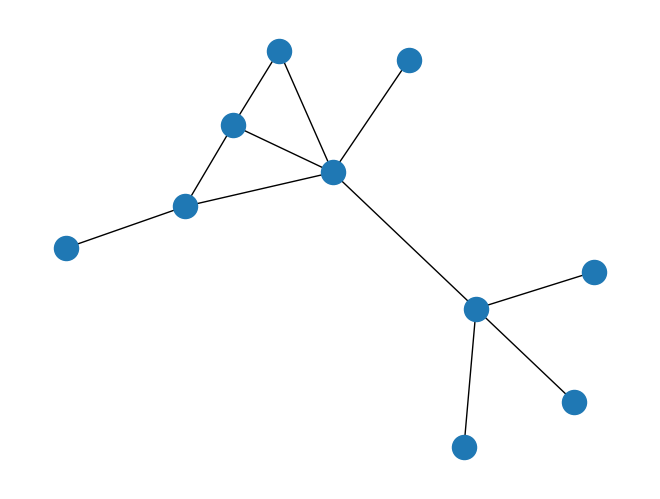

In [21]:
import pandas as pd
import glob
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


from src.graph_dataset import GraphDataset
from src.graph_parser import parseGraphmlFile
from src.graph_utils import stress, total_stress, num_crossings, mean_edge_length, nodes_dict_to_array, distance_matrix
from src.graph_utils import gradient_kamada_kawai, max_neighbour_degrees_norm, sum_neighbour_degrees_norm, expansion_factor_norm, edge_crossings_norm

def read_list_of_graphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

benchmarks = ['random-dag', 'rome', 'north']

bench = benchmarks[1]
list_graphs = read_list_of_graphs(f'../data/{bench}/','graphml')
G = list_graphs[0]
nx.draw(G)
d = nodes_dict_to_array(nx.kamada_kawai_layout(G))
print(j_node_centrality(G,d))
    


